# DeepSeek 7B PLOTS

DeepSeek VL 7B chat : https://huggingface.co/deepseek-ai/deepseek-vl-7b-chat and https://github.com/deepseek-ai/DeepSeek-VL/blob/main/README.md

LLM Disclaimer: Debugging was done with the help of ChatGPT: https://chatgpt.com/ 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
temp_rate=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [3]:
def get_metrics_deep_seek(deep_seek_df, target_col='diabetic_retinopathy', 
                           fold_numbers=list(range(10)), is_multiclass=False):
    deep_seek_df = deep_seek_df.copy()

    fold_cols = [f'output_binary_fold_{i}' for i in fold_numbers]

    deep_seek_df.loc[:, 'deepseek_answers_all_folds'] = deep_seek_df[fold_cols].max(axis=1, skipna=True)

    #print("Number of NaN in combined predictions:", deep_seek_df['deepseek_answers_all_folds'].isna().sum())

    valid_rows_all =  deep_seek_df[ deep_seek_df['deepseek_answers_all_folds'].notna()]
    y_true_all = valid_rows_all[target_col]
    y_pred_all = valid_rows_all['deepseek_answers_all_folds']

    acc_all = accuracy_score(y_true_all, y_pred_all)
    f1_all = f1_score(y_true_all, y_pred_all, average='macro' if is_multiclass else 'binary')
    #print(f"Combined folds: Accuracy = {acc_all:.4f}, F1 = {f1_all:.4f}\n")

    metrics = []
    for i in fold_numbers:
        col = f'output_binary_fold_{i}'
        col_for_cov = f'output{i}'
        col_for_cov_rows = deep_seek_df[deep_seek_df[col_for_cov].notna()]
        valid_rows = deep_seek_df[deep_seek_df[col].notna()]
        y_true = valid_rows[target_col]
        y_pred = valid_rows[col]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        precision = precision_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        recall = recall_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        acc_bal = balanced_accuracy_score(y_true, y_pred)

        metrics.append({
            'fold': i,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'acc_bal': acc_bal,
            'number_of_answers_per_fold': len(valid_rows),
            'coverage_per_fold': len(valid_rows)/len(col_for_cov_rows)
        })

        #print(f"Fold {i}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

    metrics_df = pd.DataFrame(metrics)

    return metrics_df

In [4]:
def do_one_df_metrics_DS (filenames_construction, temp_rate=temp_rate, target_col='diabetic_retinopathy'):
    all_metrics = []
    for i in temp_rate:
        performance = pd.read_csv(filenames_construction.format(tau=i))
        fold_metrics = get_metrics_deep_seek(performance)
        fold_metrics["tau"] = i
        all_metrics.append(fold_metrics)
    return pd.concat(all_metrics, ignore_index=True)

In [5]:
def plot_metrics(metrics_df, metric, temp_rate=temp_rate):
    n_taus = len(temp_rate)
    n_cols = 3
    n_rows = int(np.ceil(n_taus / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,5*n_rows), sharey=True)
    axes = axes.flatten()

    for ax, t in zip(axes, temp_rate):
        tau_df = metrics_df[metrics_df["tau"] == t]
        sns.barplot(x='fold', y=metric, data=tau_df, ax=ax, color='skyblue', errorbar=None)
        mean_val = tau_df[metric].mean()
        std_val = tau_df[metric].std()
        ax.axhline(mean_val, color='red', linestyle='--', label=f"Mean = {mean_val:.2f}")
        ax.fill_between(
            x=range(len(tau_df)),
            y1=mean_val-std_val,
            y2=mean_val+std_val,
            color='red',
            alpha=0.2,
            label="±1 SD"
        )
        for i, val in enumerate(tau_df[metric]):
            ax.text(i, val/2, f"{val:.2f}", ha='center', va='center', fontsize=10)
        ax.set_xticks(range(len(tau_df['fold'])))
        ax.set_xticklabels(tau_df['fold'], rotation=45, ha='right')
        ax.set_title(f"Tau = {t}, metric {metric}", fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel(metric)
        ax.set_ylim(0,1)
        ax.legend(loc='lower right', fontsize=10)

    for j in range(len(temp_rate), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### DS 7B, short prompt, 01, no System Instructions

In [8]:
all_metrics_deep_seek_short_taus = do_one_df_metrics_DS(filenames_construction="DS7B_shot0_short_prompt_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_01.csv")

In [7]:
#mets = [ 'accuracy', 'f1','precision','recall','acc_bal', 'coverage_per_fold']
#for i in mets:
    #plot_metrics(all_metrics_deep_seek_short_taus, i)

### DS 7B, LONG prompt, 01, no System Instructions

In [20]:
all_metrics_deep_seek_taus_long = do_one_df_metrics_DS(filenames_construction="DS7B_shot0_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_01_long.csv")

In [9]:
#for i in mets:
    #plot_metrics(all_metrics_deep_seek_taus_long, i)

### shot1

In [21]:
all_metrics_deep_seek_taus_long_shot1 = do_one_df_metrics_DS(filenames_construction="DS7B_shot1_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long.csv")

In [12]:
#for i in mets:
    #plot_metrics(all_metrics_deep_seek_taus_long_shot1, i)

### shot5

In [17]:
all_metrics_deep_seek_taus_long_shot5 = do_one_df_metrics_DS(filenames_construction="DS7B_shot5_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_5_01_long.csv")

In [14]:
#for i in mets:
    #plot_metrics(all_metrics_deep_seek_taus_long_shot5, i)

In [18]:
all_metrics_deep_seek_long_taus_r_shot_1_si1 = do_one_df_metrics_DS(filenames_construction="DS7B_shot1_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_random_shot_1_si_1_01_long.csv")
all_metrics_deep_seek_long_taus_knn_shot_1_si0 = do_one_df_metrics_DS(filenames_construction="DS7B_knn_shot_1_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_knn_shot_1_01_long.csv")
all_metrics_deep_seek_long_taus_knn_shot_1_si1 = do_one_df_metrics_DS(filenames_construction="DS7B_knn_shot_1_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_knn_shot_1_01_long_si_1.csv")
all_metrics_deep_seek_long_taus_knn_shot_5_si0 = do_one_df_metrics_DS(filenames_construction="DS7B_knn_shot_5_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_knn_shot_5_01_long_si_0.csv")

In [22]:
metrics = [
    'accuracy', 'f1', 'precision',
    'recall', 'acc_bal', 'coverage_per_fold'
]

df_short = all_metrics_deep_seek_short_taus.copy()
df_short['setting'] = 'short_shot_0'

df_long = all_metrics_deep_seek_taus_long.copy()
df_long['setting'] = 'long_shot_0'

df_shot1 = all_metrics_deep_seek_taus_long_shot1.copy()
df_shot1['setting'] = 'long_r_shot_1'

df_shot5 = all_metrics_deep_seek_taus_long_shot5.copy()
df_shot5['setting'] = 'long_r_shot_5'

df_shot1_si1 = all_metrics_deep_seek_long_taus_r_shot_1_si1.copy()
df_shot1_si1['setting'] = 'long_r_shot_1_si'

df_knn_shot1 = all_metrics_deep_seek_long_taus_knn_shot_1_si0.copy()
df_knn_shot1['setting'] = 'long_knn_shot_1'

df_knn_shot1_si1 = all_metrics_deep_seek_long_taus_knn_shot_1_si1.copy()
df_knn_shot1_si1['setting'] = 'long_knn_shot_1_si'

df_knn_shot5 = all_metrics_deep_seek_long_taus_knn_shot_5_si0.copy()
df_knn_shot5['setting'] = 'long_knn_shot_5'

#df_all = pd.concat([df_shot1, df_shot1_si1, df_knn_shot1, df_knn_shot1_si1], ignore_index=True)
#df_all = pd.concat([df_long, df_shot1, df_shot5, df_knn_shot1, df_knn_shot5], ignore_index=True)
df_all = pd.concat([df_short, df_long, df_shot1, df_shot5, df_shot1_si1, df_knn_shot1, df_knn_shot1_si1, df_knn_shot5], ignore_index=True)

In [23]:
df_long_metrics = df_all.melt(
    id_vars=['fold', 'tau', 'setting'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)

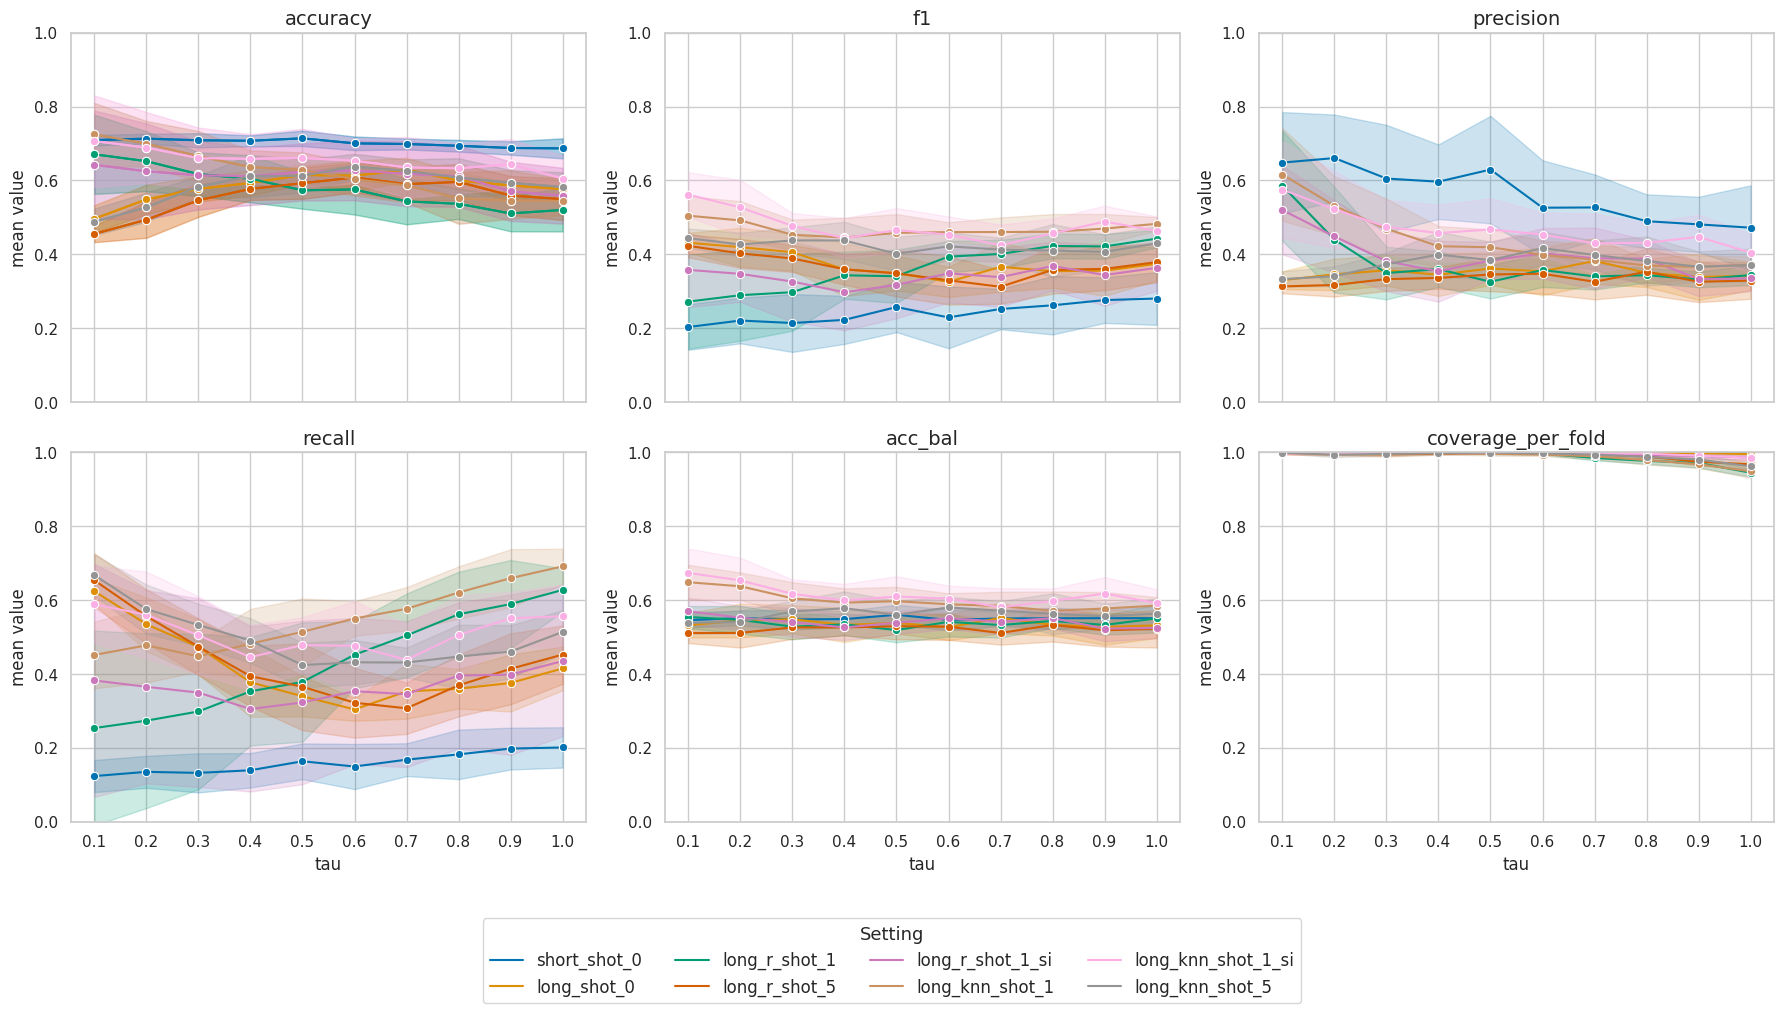

In [24]:
sns.set(style="whitegrid", palette="colorblind")

taus = np.sort(df_long_metrics['tau'].unique())
metrics = df_long_metrics['metric'].unique()

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

subset_first = df_long_metrics[df_long_metrics['metric'] == metrics[0]]
g = sns.lineplot(
    data=subset_first,
    x='tau',
    y='value',
    hue='setting',
    estimator='mean',
    errorbar='sd',
    marker='o',
    ax=axes[0],
)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove()

for ax, metric in zip(axes, metrics):
    subset = df_long_metrics[df_long_metrics['metric'] == metric]
    sns.lineplot(
        data=subset,
        x='tau',
        y='value',
        hue='setting',
        estimator='mean',
        errorbar='sd',
        marker='o',
        ax=ax,
        legend=False
    )
    
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("tau", fontsize=12)
    ax.set_ylabel("mean value", fontsize=12)
    ax.set_xticks(taus)
    ax.set_xticklabels([f"{t:.1f}" for t in taus])
    ax.set_ylim(0, 1)

fig.legend(
    handles,
    labels,
    title="Setting",
    loc='lower center',
    ncol=min(4, len(labels)),
    bbox_to_anchor=(0.5, -0.02),
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()